# Import packages

In [1]:
!pip install import_ipynb
!pip install underthesea
!pip install demoji
!pip install pyvi
!pip install lightgbm

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
%cd '/content/gdrive/MyDrive/LDS0_K273_DamThiMinhPhuong/Project/Project3_SentimentAnalysis'

/content/gdrive/MyDrive/LDS0_K273_DamThiMinhPhuong/Project/Project3_SentimentAnalysis


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import import_ipynb
import Lib3

pd.options.display.float_format = '{:,.4f}'.format

importing Jupyter notebook from Lib3.ipynb


In [2]:
from underthesea import word_tokenize, pos_tag, sent_tokenize
import regex
import demoji
from pyvi import ViPosTagger, ViTokenizer
import string
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression, SGDClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Step 1: Business Understanding

# Step 2: Data Understanding

# Step 3: Data Preparation

In [3]:
# Load foodyClean.csv
df = pd.read_csv('data/foodyDataFinal_clean2.csv', index_col=0)

In [4]:
df.shape

(33632, 6)

In [5]:
text_data = np.array(df['review_text_clean'])
text_data

array(['gà mắm phô kéo sợi siêu ngon giá mềm .',
       'gà hàn phô kéo sợi siêu ngon giá mềm .', 'gà tây mặn .', ...,
       'đường trần_diệu sâu xíu không_có giới_thiệu không_biết . ngon nổi_tiếng vực bình thủy bạn_bè rủ_rê đấy . đồ ngon nêm nếm đậm_đà . phục_vụ mực đặc_sản gương_mặt thương_hiệu . phục_vụ thích_hợp nhâm bạn_bè đình . giá_cả hợp_lý thị_trường . ngon .',
       'trời mưa lạnh thèm bún_bò đầu chiều . tái nạm đem không_. bọc nguội_ngắt . lát tái nạm . không_hành_tây . nấu sôi thèm ngon_miệng . không_biết không_đúng không_nước nguội đem đâu không_có bếp nấu nghỉ .',
       'chủ_yếu thích bún_bò bún_bò không_để giò bò bò viên . hấp_dẫn hương_vị đậm_đà bò bò viên ngon bò viên sần_sật không_bột tương ngon . tí tế đỉnh . sạch_sẽ thoáng mấy vẻ yêu .'],
      dtype=object)

In [6]:
tfidf = TfidfVectorizer(max_features=None) 
bag_of_words = tfidf.fit_transform(text_data)
bag_of_words

<33632x23923 sparse matrix of type '<class 'numpy.float64'>'
	with 736961 stored elements in Compressed Sparse Row format>

In [7]:
X = bag_of_words.toarray()
X.shape

(33632, 23923)

In [8]:
y = np.array(df['label'])
y.shape

(33632,)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train[:5], y_train[:5]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([1, 1, 1, 1, 1]))

# Step 4: Build Model & Evaluate



Ta sẽ đặt mục tiêu của project là phát hiện càng nhiều càng tốt các review xấu (class 0), nên bên cạnh Accuracy ta sẽ quan tâm tới cả các chỉ số Precision, Recall của class 0

Trước hết, ta sẽ xem xét một lượt các thuật toán, bao gồm:
- 5 thuật toán có kết quả tốt nhất do **lazypredict**
- Các thuật toán có **Tree-based** để deal với việc mất cân bằng của dữ liệu: **LGBMClassifier**

In [11]:
models_list = [BernoulliNB(), NearestCentroid(), SGDClassifier(), LogisticRegression()]
results = Lib3.average_score_multiple_models(models_list, X, y, test_size=0.2, cv=5, average='micro')
results

,Model,Score_Train,Score_Test,Precision,Recall,F1,Time Fit
0,BernoulliNB,0.9102,0.8930,0.8930,0.8930,0.8930,5.0339
1,NearestCentroid,0.8467,0.8454,0.8454,0.8454,0.8454,2.2575
2,SGDClassifier,0.9223,0.9004,0.9004,0.9004,0.9004,14.7137
3,LogisticRegression,0.9201,0.9018,0.9018,0.9018,0.9018,20.2467


In [11]:
models_list = [LGBMClassifier()]
results = Lib3.average_score_multiple_models(models_list, X, y, test_size=0.2, cv=5, average='micro')
results

,Model,Score_Train,Score_Test,Precision,Recall,F1,Time Fit
0,LGBMClassifier,0.9160,0.8899,0.8899,0.8899,0.8899,3.9559


Các thuật toán đều cho kết quả tốt trên cross validation nên ta sẽ xem xét lần lượt từng thuật toán với confusion matrix và classification report

### Model 1: BernouliNB

In [12]:
nbModel = BernoulliNB() 
Lib3.build_n_evaluate_model(nbModel, X_train,y_train, X_test, y_test)

--- Accuracy train: 0.9138136097188004
--- Accuracy test: 0.8904856293359762 
--- Recall: 0.8904856293359762 , Precision: 0.8904856293359762 , F1: 0.8904856293359762
--- Confusion matrix
 [[2062  669]
 [ 436 6923]]
--- Classification report
               precision    recall  f1-score   support

           0       0.83      0.76      0.79      2731
           1       0.91      0.94      0.93      7359

    accuracy                           0.89     10090
   macro avg       0.87      0.85      0.86     10090
weighted avg       0.89      0.89      0.89     10090



### Model 2: NearestCentroid

In [13]:
ncModel = NearestCentroid()
Lib3.build_n_evaluate_model(ncModel, X_train,y_train, X_test, y_test)

--- Accuracy train: 0.8503525613796619
--- Accuracy test: 0.8402378592666006 
--- Recall: 0.8402378592666006 , Precision: 0.8402378592666006 , F1: 0.8402378592666006
--- Confusion matrix
 [[2317  414]
 [1198 6161]]
--- Classification report
               precision    recall  f1-score   support

           0       0.66      0.85      0.74      2731
           1       0.94      0.84      0.88      7359

    accuracy                           0.84     10090
   macro avg       0.80      0.84      0.81     10090
weighted avg       0.86      0.84      0.85     10090



### Model 3: SGDClassifier

In [14]:
sgdModel = SGDClassifier()
Lib3.build_n_evaluate_model(sgdModel, X_train,y_train, X_test, y_test)

--- Accuracy train: 0.9287231331237787
--- Accuracy test: 0.8989098116947473 
--- Recall: 0.8989098116947473 , Precision: 0.8989098116947473 , F1: 0.8989098116947473
--- Confusion matrix
 [[2096  635]
 [ 385 6974]]
--- Classification report
               precision    recall  f1-score   support

           0       0.84      0.77      0.80      2731
           1       0.92      0.95      0.93      7359

    accuracy                           0.90     10090
   macro avg       0.88      0.86      0.87     10090
weighted avg       0.90      0.90      0.90     10090



### Model 4: LogisticRegression

In [15]:
logisModel = LogisticRegression(solver = 'sag', penalty = 'l2', C=10) 
Lib3.build_n_evaluate_model(logisModel, X_train,y_train, X_test, y_test)

--- Accuracy train: 0.9530201342281879
--- Accuracy test: 0.8922695738354807 
--- Recall: 0.8922695738354807 , Precision: 0.8922695738354807 , F1: 0.8922695738354807
--- Confusion matrix
 [[2065  666]
 [ 421 6938]]
--- Classification report
               precision    recall  f1-score   support

           0       0.83      0.76      0.79      2731
           1       0.91      0.94      0.93      7359

    accuracy                           0.89     10090
   macro avg       0.87      0.85      0.86     10090
weighted avg       0.89      0.89      0.89     10090



### Model 5: LGBMClassifier

In [16]:
lgbmModel = LGBMClassifier() 
Lib3.build_n_evaluate_model(lgbmModel, X_train,y_train, X_test, y_test)

--- Accuracy train: 0.9189533599524254
--- Accuracy test: 0.8854311199207135 
--- Recall: 0.8854311199207135 , Precision: 0.8854311199207135 , F1: 0.8854311199207135
--- Confusion matrix
 [[2021  710]
 [ 446 6913]]
--- Classification report
               precision    recall  f1-score   support

           0       0.82      0.74      0.78      2731
           1       0.91      0.94      0.92      7359

    accuracy                           0.89     10090
   macro avg       0.86      0.84      0.85     10090
weighted avg       0.88      0.89      0.88     10090



Nhận xét:
- Các model đều cho Accuracy khá cao trên cả train và test (>90%), tuy nhiên ta có thể thấy F1 score của class 0 cho kết quả chưa tối ưu. Điều này có thể do sự mất cân bằng dữ liệu.
- => Ta sẽ lựa chọn 3 thuật toán cho kết quả tốt nhất: **BernoulliNB, SGDClassifier, LogisticRegression** để tiến hành cân bằng dữ liệu bằng phương pháp Oversampling, Undersampling và xây dựng model mới trên dữ liệu này

## Oversampling data

In [19]:
Counter(y_train)

Counter({1: 17312, 0: 6230})

In [20]:
# Oversampling
sm = SMOTE()
X_resample, y_resample = sm.fit_resample(X_train, y_train)

In [21]:
Counter(y_resample)

Counter({1: 17312, 0: 17312})

### Model 1: BernoulliNB

In [22]:
nbModel_o = BernoulliNB() 
Lib3.build_n_evaluate_model_balanced(nbModel_o, X_resample, y_resample, X_test, y_test)

--- Accuracy train: 0.889527495378928
--- Accuracy test: 0.8594648166501486 
--- Recall: 0.8575997457187186 , Precision: 0.8183451440889147 , F1: 0.8331044699514745
--- Confusion matrix
 [[2331  400]
 [1018 6341]]
--- Classification report
               precision    recall  f1-score   support

           0       0.70      0.85      0.77      2731
           1       0.94      0.86      0.90      7359

    accuracy                           0.86     10090
   macro avg       0.82      0.86      0.83     10090
weighted avg       0.87      0.86      0.86     10090



### Model 3: SGDClassifier

In [23]:
sgdModel_o = SGDClassifier()
Lib3.build_n_evaluate_model_balanced(sgdModel_o, X_resample, y_resample, X_test, y_test)

--- Accuracy train: 0.9217594731977818
--- Accuracy test: 0.8730426164519326 
--- Recall: 0.8662172410212272 , Precision: 0.8338182601596517 , F1: 0.8470575702266002
--- Confusion matrix
 [[2325  406]
 [ 875 6484]]
--- Classification report
               precision    recall  f1-score   support

           0       0.73      0.85      0.78      2731
           1       0.94      0.88      0.91      7359

    accuracy                           0.87     10090
   macro avg       0.83      0.87      0.85     10090
weighted avg       0.88      0.87      0.88     10090



### Model 4: LogisticRegression

In [24]:
logisModel_o = LogisticRegression(solver = 'sag', penalty = 'l2', C=10) 
Lib3.build_n_evaluate_model_balanced(logisModel_o,  X_resample, y_resample, X_test, y_test)

--- Accuracy train: 0.9607786506469501
--- Accuracy test: 0.8711595639246779 
--- Recall: 0.8542183679315399 , Precision: 0.8325975555554621 , F1: 0.8421422992880916
--- Confusion matrix
 [[2232  499]
 [ 801 6558]]
--- Classification report
               precision    recall  f1-score   support

           0       0.74      0.82      0.77      2731
           1       0.93      0.89      0.91      7359

    accuracy                           0.87     10090
   macro avg       0.83      0.85      0.84     10090
weighted avg       0.88      0.87      0.87     10090



Nhận xét:
- Có thể thấy rằng mô hình xây dựng trên dữ liệu đã cân bằng giúp tăng recall của lớp 0 nhưng đồng thời cũng làm giảm precision của lớp này 

## Undersampling data

In [25]:
from imblearn.under_sampling import NearMiss
nm = NearMiss()
X_resample, y_resample = nm.fit_resample(X_train, y_train)
print('Original dataset shape:', Counter(y_train))
print('Resample dataset shape:', Counter(y_resample))

Original dataset shape: Counter({1: 17312, 0: 6230})
Resample dataset shape: Counter({0: 6230, 1: 6230})


In [26]:
nbModel_u = BernoulliNB() 
Lib3.build_n_evaluate_model_balanced(nbModel_u, X_resample, y_resample, X_test, y_test)

--- Accuracy train: 0.8804975922953451
--- Accuracy test: 0.8642220019821606 
--- Recall: 0.8614367539250916 , Precision: 0.8236294249803823 , F1: 0.8381759615543556
--- Confusion matrix
 [[2336  395]
 [ 975 6384]]
--- Classification report
               precision    recall  f1-score   support

           0       0.71      0.86      0.77      2731
           1       0.94      0.87      0.90      7359

    accuracy                           0.86     10090
   macro avg       0.82      0.86      0.84     10090
weighted avg       0.88      0.86      0.87     10090



In [27]:
sgdModel_u = SGDClassifier()
Lib3.build_n_evaluate_model_balanced(sgdModel_u, X_resample, y_resample, X_test, y_test)

--- Accuracy train: 0.9199036918138042
--- Accuracy test: 0.86798810703667 
--- Recall: 0.861370427033229 , Precision: 0.8279292439154354 , F1: 0.8413886659577243
--- Confusion matrix
 [[2313  418]
 [ 914 6445]]
--- Classification report
               precision    recall  f1-score   support

           0       0.72      0.85      0.78      2731
           1       0.94      0.88      0.91      7359

    accuracy                           0.87     10090
   macro avg       0.83      0.86      0.84     10090
weighted avg       0.88      0.87      0.87     10090



In [28]:
logisModel_u = LogisticRegression(solver = 'sag', penalty = 'l2', C=10) 
Lib3.build_n_evaluate_model_balanced(logisModel_u,  X_resample, y_resample, X_test, y_test)

--- Accuracy train: 0.9469502407704655
--- Accuracy test: 0.8550049554013875 
--- Recall: 0.8523546220762865 , Precision: 0.8133469066126993 , F1: 0.8279206572230275
--- Confusion matrix
 [[2312  419]
 [1044 6315]]
--- Classification report
               precision    recall  f1-score   support

           0       0.69      0.85      0.76      2731
           1       0.94      0.86      0.90      7359

    accuracy                           0.86     10090
   macro avg       0.81      0.85      0.83     10090
weighted avg       0.87      0.86      0.86     10090



<font color='blue'> **Nhận xét** </font>
- Có thể thấy kết quả của mô hình xây dựng trên dữ liệu undersampling cho kết quả không tốt bằng oversampling
- Ta sẽ so sánh 2 kết quả tốt nhất sau khi chạy một loạt thuật toán và data options ở trên:
    + <font color='green'>**SGDClassifier - unbalanced data**</font> 
        + --- Accuracy train: 0.9287 --- Accuracy test: 0.8989
        + --- Class 0: precision-0.84, recall-0.77
        + --- Confusion matrix
                              [[2096  635]
                              [ 385 6974]]
        
    + <font color='green'>**SGDClassifier - oversampling data**</font>
        + --- Accuracy train: 0.9217 --- Accuracy test: 0.8730
        + --- Class 0: precision-0.73, recall-0.85
        + --- Confusion matrix
                              [[2325  406]
                              [ 875 6484]]
        
- => **SGDClassifier - unbalanced data** có accuracy train-test cân bằng hơn **SGDClassifier - oversampling data**
- => Với **SGDClassifier - unbalanced data** dữ liệu class 0 bị dự đoán sai tuy cao hơn nhưng số lượng dữ liệu bị đọc nhầm chỉ 385 entries. Trong khi đó với **SGDClassifier - oversampling data** tuy số lượng dữ liệu class 0 bị dự đoán sai ít hơn một chút nhưng bù lại ố lượng dữ liệu bị đọc nhầm khá cao 875 entries (chiếm 27%)
- <font color='blue'>=> Ta sẽ chọn model **SGDClassifier - unbalanced data**</font>

In [31]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
def ROC_AUC(y, y_prob):
    #calculate roc curves
    fpr, tpr, threshold = roc_curve(y, y_prob)
    #calculate scores
    model_auc = roc_auc_score(y, y_prob)
    #plot the roc curve for the model
    plt.plot([0,1],[0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='Model - AUC=%.3f' %(model_auc))
    #show axis labels and the legend
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show(block=False)
    return

In [58]:
from sklearn.calibration import CalibratedClassifierCV
sgdModel.fit(X_train, y_train)
calibrator = CalibratedClassifierCV(sgdModel, cv='prefit')
model=calibrator.fit(X_train, y_train)

y_train_pred = model.predict_proba(X_train)
y_test_pred = model.predict_proba(X_test)[::,1]

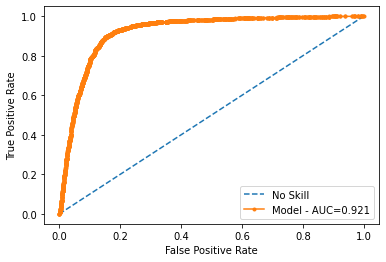

In [59]:
Lib3.ROC_AUC(y_test, y_test_pred)

In [ ]:
#parameter tuning
import time
sgdModel = SGDClassifier()
params = {
    "loss" : ["hinge", "log", "modified_huber"],
    "alpha" : [0.01, 0.001,0.0001],
    "penalty" : ["l2", "l1", "none"]
    "class_weight" : [{1:0.4, 0:0.6},{1:0.5, 0:0.5},{1:0.6, 0:0.4}]
}

sgd_tune = RandomizedSearchCV(sgdModel, params, cv=3)
t0 = time.time()
sgd_tune.fit(X_train, y_train)
t1 = time.time() - t0

In [ ]:
print("Best parameters set:")
print(sgd_tune.best_params_)
print('Mean Accuracy: %.3f' % sgd_tune.best_score_)
print(t1)

In [21]:
sgdModel_tuned = SGDClassifier(penalty='l1', loss='hinge', alpha=0.0001, class_weight = {1:0.4, 0:0.6})
Lib3.build_n_evaluate_model(sgdModel_tuned, X_train,y_train, X_test, y_test)

--- Accuracy train: 0.8879874267267012
--- Accuracy test: 0.8745292368681863 
--- Recall: 0.8745292368681863 , Precision: 0.8745292368681863 , F1: 0.8745292368681863
--- Confusion matrix
 [[2223  508]
 [ 758 6601]]
--- Classification report
               precision    recall  f1-score   support

           0       0.75      0.81      0.78      2731
           1       0.93      0.90      0.91      7359

    accuracy                           0.87     10090
   macro avg       0.84      0.86      0.85     10090
weighted avg       0.88      0.87      0.88     10090



SGDClassifier với default parameter cho kết quả confusion matrix & precision, recall của class 0 tốt hơn

# STEP 5: Save model & Predict new data

In [24]:
# Load foodyClean.csv
df2 = pd.read_csv('data/foodyDataFinal_clean2.csv', index_col=0)
df2.head(3)

,name,review_text,review_score,review_score_bins,label,review_text_clean
0,Chícc Chícc - Gà Rán Hàn Quốc,"Gà tắm mắm, phô mai kéo sợi siêu ngon, giá mềm",10.0000,"(9, 10]",1,gà mắm phô kéo sợi siêu ngon giá mềm .
1,Chícc Chícc - Gà Rán Hàn Quốc,"Gà BBQ Hàn, phô mai kéo sợi siêu ngon, giá mềm",10.0000,"(9, 10]",1,gà hàn phô kéo sợi siêu ngon giá mềm .
11,Chícc Chícc - Gà Rán Hàn Quốc,Gà với khoai tây quá mặn,1.0000,"(0, 1]",0,gà tây mặn .


In [25]:
X = df2.review_text_clean
y = df2.label

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [42]:
final_pipe = Pipeline(steps=[
                            ('bow', TfidfVectorizer()),
                            ('clf', SGDClassifier())
                            ])
# Fit final_pipe on training set
final_pipe.fit(X_train, y_train)

Pipeline(steps=[('bow', TfidfVectorizer()), ('clf', SGDClassifier())])

In [31]:
#LOAD EMOJICON
file = open('files/emojicon.txt', 'r', encoding="utf8")
emoji_lst = file.read().split('\n')
emoji_dict = {}
for line in emoji_lst:
    key, value = line.split('\t')
    emoji_dict[key] = str(value)
file.close()

#LOAD TEENCODE
file = open('files/teencode.txt', 'r', encoding="utf8")
teen_lst = file.read().split('\n')
teen_dict = {}
for line in teen_lst:
    key, value = line.split('\t')
    teen_dict[key] = str(value)
file.close()

#LOAD TRANSLATE ENGLISH -> VNMESE
file = open('files/english-vnmese.txt', 'r', encoding="utf8")
english_lst = file.read().split('\n')
english_dict = {}
for line in english_lst:
    key, value = line.split('\t')
    english_dict[key] = str(value)
file.close()

#LOAD wrong words
file = open('files/wrong-word.txt', 'r', encoding="utf8")
wrong_lst = file.read().split('\n')
file.close()

#LOAD STOPWORDS
file = open('files/vietnamese-stopwords.txt', 'r', encoding="utf8")
stopwords_lst = file.read().split('\n')
file.close()

In [36]:
X_new = [
         '- đồ ăn tạm tàm nhưng nhân viên thái độ lồi lõm, đúng là một lần và mãi mãi',
         'quán dở bà cố mà review ảo tung chảo',
         'Quán xập xệ, nóng bức làm ăn mất cả ngon',
         'bánh không ngon mà phải gọi là bánh cực kì cực kì ngon í',
         'Quán giảm 50% và lượng nước cũng giảm 50% kèm thêm 1 ly toàn đá, hút 2 hơi là hết ly nước lạt nhách. Làm vậy thà đừng giảm. Lên đây viết review mới phát hiện có nhiều bạn nói quán fake, thật sai lầm khi không đọc review trước khi mua.'
]

In [37]:
X_new = [Lib3.clean_text_thesea(x, emoji_dict, teen_dict, wrong_lst,stopwords_lst) for x in X_new]

In [39]:
final_pipe.predict(X_new)

array([0, 0, 0, 1, 0])

In [40]:
import pickle
# Save to file in the current working directory 

pkl_filename = "foody_sentiment_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(final_pipe, file)